<h3>Dependencies

In [1]:
import sys, os

filePath = "F:\\TUDelft\\ResearchAssistant\\research\\code\\current\\RK4_SinDy_packages"
sys.path.insert(0, filePath)

import numpy as np
import torch as T
import os
from scipy.integrate import solve_ivp
from dataclasses import dataclass
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
import pysindy as ps
import polynomial_library_torch as pl_torch
from utils import printing_learned_model
from modules import coeffs_dictionary
from models import sdof_free_vibr, sdof_harmonic, sdof_friction
from learning_models import learning_sparse_model
from IPython.utils.io import Tee
from contextlib import closing
import tikzplotlib

<h4> Random Seed

In [2]:
randSeed = 42

T.manual_seed(randSeed)
np.random.seed(seed=randSeed)

In [3]:
dynModel = sdof_friction

In [4]:
ts = np.arange(0, 50, 0.1)

# Initial condition and simulation time
x0 = [0.1, 0.1]

# Solve the equation
sol = solve_ivp(lambda t, x: dynModel(x, t), t_span=[ts[0], ts[-1]], y0=x0, t_eval=ts)
x = np.transpose(sol.y)

# Generate noisy measurements
# x = np.random.normal(loc=x, scale=parameters.noise_level * np.abs(x), size=x.shape)

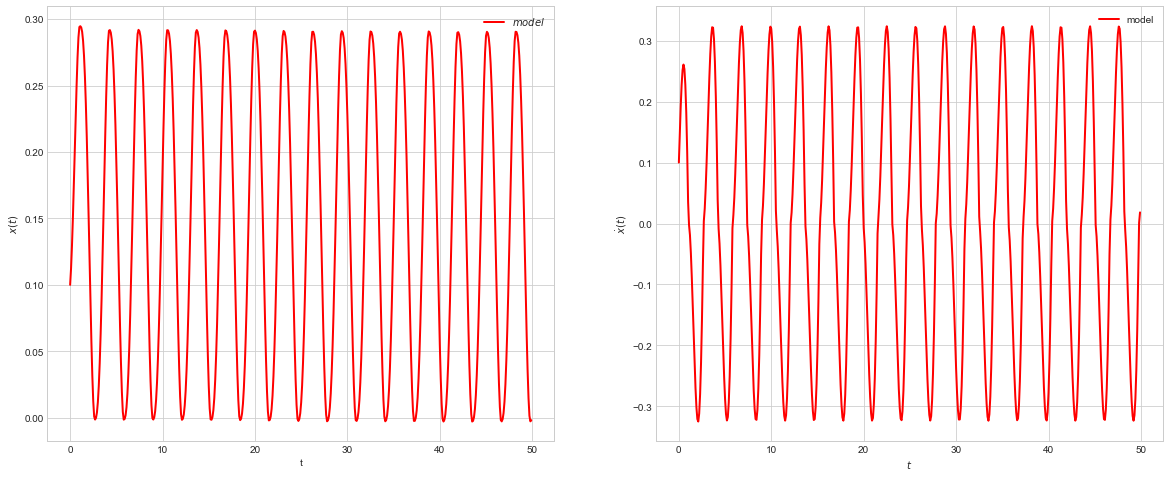

In [5]:
plot_kws = dict(linewidth=2)
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].plot(ts, x[:, 0], "r", markersize=4, label="$model$", **plot_kws)

axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x(t)$")

axs[1].plot(ts, x[:, 1], "r", markersize=4, label="model", **plot_kws)
axs[1].legend()

axs[1].set(xlabel="$t$", ylabel="$\dot{x}(t)$")

plt.show()

In [7]:
import torch_optimizer as optim_all


def learning_sparse_model(
    dictionary,
    Coeffs,
    train_set,
    times,
    Params,
    lr_reduction=10,
    forced=True,
    quite=False,
):

    """
    Parameters
    ----------
    dictionary : A function
        It is a symbolic dictionary, containing potential candidate functions that describes dynamics.
    Coeffs : float
        Coefficients that picks correct features from the dictionary .
    train_set : tensor
        Containing training data that follows PyTorch framework.
    times : tensor
        Containing the discrete time values corresponfing to the collected training data
    Params : dataclass
        Containing additional auxilary parameters.
    lr_reduction : float, optional
        The learning rate is reduced by lr_reduction after each iteration. The default is 10.
    quite : bool, optional
        It decides whether to print coeffs after each iteration. The default is False.

    Returns
    -------
    Coeffs : float
        Non-zero coefficients picks features from the dictionary and
        also determines right coefficients in front of the features.
    loss_track : float
        tacking loss after each epoch and iteration.

    """

    # Define optimizer
    opt_func = optim_all.RAdam(
        Coeffs.parameters(), lr=Params.lr, weight_decay=Params.weightdecay
    )
    # Define loss function
    criteria = T.nn.MSELoss()
    # pre-allocate memory for loss_fuction
    loss_track = np.zeros((Params.num_iter, Params.num_epochs))
    #########################
    ###### Training #########
    #########################
    for p in range(Params.num_iter):
        for g in range(Params.num_epochs):
            Coeffs.train()

            opt_func.zero_grad()

            loss_new = T.autograd.Variable(T.tensor([0.0], requires_grad=True))
            weights = 2 ** (-0.5 * T.linspace(0, 0, 1))

            timesteps_i = T.tensor(np.diff(times, axis=0)).float()
            # times = torch.tensor(y[1][i]).float()
            y_total = train_set

            y_pred = rk4th_onestep_SparseId_Force_and_Friction(
                    y_total[:-1],
                    dictionary,
                    Coeffs,
                    times[:-1],
                    timestep=timesteps_i,
            )

            y_pred_back = rk4th_onestep_SparseId_Force_and_Friction(
                    y_total[1:],
                    dictionary,
                    Coeffs,
                    times[1:],
                    timestep=-timesteps_i,
            )
            loss_new += criteria(y_pred, y_total[1:]) + weights[0] * criteria(
                y_pred_back, y_total[:-1]
            )

            # loss_new /= y[0].shape[0]
            loss_track[p, g] += loss_new.item()
            loss_new.backward()
            opt_func.step()

            sys.stdout.write(
                "\r [Iter %d/%d] [Epoch %d/%d] [Training loss: %.2e] [Learning rate: %.2e]"
                % (
                    p + 1,
                    Params.num_iter,
                    g + 1,
                    Params.num_epochs,
                    loss_track[p, g],
                    opt_func.param_groups[0]["lr"],
                )
            )

        # Removing the coefficients smaller than tol and set gradients w.r.t. them to zero
        # so that they will not be updated in the iterations
        Ws = Coeffs.linear.weight.detach().clone()
        Mask_Ws = (Ws.abs() > Params.tol_coeffs).type(T.float)
        Coeffs.linear.weight = T.nn.Parameter(Ws * Mask_Ws)

        if not quite:
            print("\n")
            print(Ws)
            print(
                "\nError in coeffs due to truncation: {}".format(
                    (Ws - Coeffs.linear.weight).abs().max()
                )
            )
            print("Printing coeffs after {} iter after truncation".format(p + 1))
            print(Coeffs.linear.weight)
            print("\n" + "=" * 50)

        Coeffs.linear.weight.register_hook(lambda grad: grad.mul_(Mask_Ws))
        new_lr = opt_func.param_groups[0]["lr"] / lr_reduction
        opt_func = optim_all.RAdam(
            Coeffs.parameters(), lr=new_lr, weight_decay=Params.weightdecay
        )

    return Coeffs, loss_track

In [8]:
@dataclass
class parameters:
    bs: int = 1
    num_epochs: int = 1000
    num_iter = 3
    lr: float = 1e-1
    # save_model_path: str = "./Results/SDOF_free_vibration/"
    save_model_path: str = "./Results/Refactored/"
    weightdecay: float = 0.0
    NumInitial: int = 1
    dim_x: int = 2
    timefinal: float = 50.0
    timestep: float = 1e-1
    normalize: bool = False
    tol_coeffs: float = 5e-2
    poly_order: int = 2
    tikz_save: bool = False
    noise_level: float = 1e-2
    forced: bool = True

Params = parameters()

os.makedirs(os.path.dirname(Params.save_model_path), exist_ok=True)

In [9]:
# Define dataloaders
train_dset = T.tensor(x).float()
times = T.tensor(ts).unsqueeze(1).float()

# defining library
funs_dictionary = pl_torch.PolynomialLibrary(degree=Params.poly_order)
funs_dictionary.fit(x)
funs_dictionary_size = funs_dictionary.transform(x).shape[1]

Coeffs = coeffs_dictionary(funs_dictionary_size, Params.dim_x)

# Learning Coefficients
Coeffs, loss_track = learning_sparse_model(funs_dictionary, Coeffs, train_dset, times, Params, forced=Params.forced, quite=True)
Learned_Coeffs = Coeffs.linear.weight.detach().clone().t().numpy()

 [Iter 3/3] [Epoch 1000/1000] [Training loss: 1.45e-03] [Learning rate: 1.00e-03]

<h3> Parameters

In [46]:
@dataclass
class parameters:
    bs: int = 1
    num_epochs: int = 1000
    num_iter = 3
    lr: float = 1e-2
    # save_model_path: str = "./Results/SDOF_free_vibration/"
    save_model_path: str = "./Results/Refactored/"
    weightdecay: float = 0.0
    NumInitial: int = 1
    dim_x: int = 2
    timefinal: float = 50.0
    timestep: float = 2e-1
    normalize: bool = False
    tol_coeffs: float = 5e-2
    poly_order: int = 2
    tikz_save: bool = False
    noise_level: float = 1e-2
    forced: bool = True

Params = parameters()

os.makedirs(os.path.dirname(Params.save_model_path), exist_ok=True)

<h4>Model

In [47]:
if Params.forced:
    dynModel = sdof_harmonic
else:
    dynModel = sdof_free_vibr

<h4> Logging

In [79]:
with closing(
    Tee(
        # f"{Params.save_model_path}Noisy_SDOF_free_vibration.log",
        f"{Params.save_model_path}Noisy_SDOF_Harmonic_Excitation.log",
        "a+",
        channel="stdout",
    )
) as outputstream:
    # printing of the learned sparse models in a file
    
    print(f"\n{'*'*100}")
    print(f"{'*'*10} TIME STEP {parameters.timestep:.3f} {'*'*10}")
    print(f"{10*'*'} POLYNOMIAL ORDER {parameters.poly_order:.0f} {10*'*'}")
    print(f"{10*'*'} NOISE LEVEL {parameters.noise_level:.3f} {10*'*'}")


****************************************************************************************************
********** TIME STEP 0.100 **********
********** POLYNOMIAL ORDER 2 **********
********** NOISE LEVEL 0.010 **********


In [5]:
ts = np.arange(0, Params.timefinal, Params.timestep)

# Initial condition and simulation time
x0 = [0.1, 0.1]

# Solve the equation
sol = solve_ivp(lambda t, x: dynModel(x, t), t_span=[ts[0], ts[-1]], y0=x0, t_eval=ts)
x = np.transpose(sol.y)

# Generate noisy measurements
x = np.random.normal(loc=x, scale=parameters.noise_level * np.abs(x), size=x.shape)

In [7]:
# Define dataloaders
train_dset = T.tensor(x).float()
times = T.tensor(ts).unsqueeze(1).float()

# defining library
funs_dictionary = pl_torch.PolynomialLibrary(degree=Params.poly_order)
funs_dictionary.fit(x)
funs_dictionary_size = funs_dictionary.transform(x).shape[1]

Coeffs = coeffs_dictionary(funs_dictionary_size, Params.dim_x)

# Learning Coefficients
Coeffs, loss_track = learning_sparse_model(funs_dictionary, Coeffs, train_dset, times, Params, forced=Params.forced, quite=True)
Learned_Coeffs = Coeffs.linear.weight.detach().clone().t().numpy()

 [Iter 3/3] [Epoch 1000/1000] [Training loss: 6.14e-05] [Learning rate: 1.00e-04]

In [11]:
# Simulate all identified model
learnt_deri = lambda t, z: (funs_dictionary.transform(np.expand_dims(z, axis=0)) @ Learned_Coeffs).reshape(-1,) + Params.forced * np.array([0, np.cos(2 * t)])

ts_refine = np.arange(0, Params.timefinal, 1e-2)

# sol = solve_ivp(lambda t, x: dynModel(x, t), [ts_refine[0], ts_refine[-1]], x0, t_eval=ts_refine)
# x_refine = np.transpose(sol.y)

sol_learnt = solve_ivp(learnt_deri, [ts_refine[0], ts_refine[-1]], x0, t_eval=ts_refine,)
x_learnt = np.transpose(sol_learnt.y)

<h3>Plotting

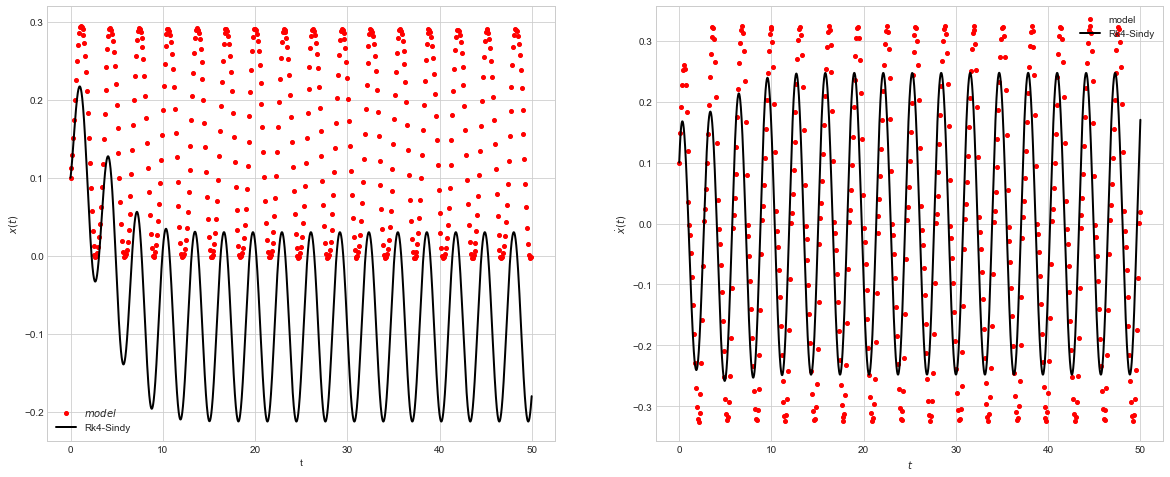

In [12]:
plot_kws = dict(linewidth=2)
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].plot(ts, x[:, 0], "ro", markersize=4, label="$model$", **plot_kws)
axs[0].plot(ts_refine, x_learnt[:, 0], "k-", label="Rk4-Sindy", **plot_kws)

axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x(t)$")

axs[1].plot(ts, x[:, 1], "ro", markersize=4, label="model", **plot_kws)
axs[1].plot(ts_refine, x_learnt[:, 1], "k-", markersize=4, label="Rk4-Sindy",**plot_kws)

axs[1].legend()

axs[1].set(xlabel="$t$", ylabel="$\dot{x}(t)$")

plt.show()

<h4> Logging

In [84]:
with closing(
    Tee(
        # f"{Params.save_model_path}Noisy_SDOF_free_vibration.log",
        f"{Params.save_model_path}Noisy_SDOF_harmonic_excitation.log",
        "a+",
        channel="stdout",
    )
) as outputstream:
    # printing of the learned sparse models in a file
    print(f"{'='*50}\nRK4 Inspired Methods Sparse Identification")
    printing_learned_model(Learned_Coeffs, funs_dictionary.get_feature_names())
    # print(f"{'='*50}\nSindy Approach")
    # model.print()
    print(f"{'='*50}\n{'*'*100}")


RK4 Inspired Methods Sparse Identification
dx0'= 1.000 x1 
dx1'= -1.001 x0 + -0.101 x1 
****************************************************************************************************


In [13]:
printing_learned_model(Learned_Coeffs, funs_dictionary.get_feature_names())

dx0'= 0.983 x1 
dx1'= -0.192 1 + -0.575 x0 + -3.953 x1 + 6.676 x0^2 + -0.754 x0 x1 + 1.179 x1^2 
